In [1]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import importlib.util #import from superordinate folder
spec = importlib.util.spec_from_file_location("helper", 
                                              str(re.search("(.*/)",os.getcwd()).groups(0)[0])+"helper.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

In [2]:
#Now you can zoom
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
prefix = "RPS_C_13_C3_left_"

In [4]:
with open("DualEEG_RPS_C_13.power_common_reference","rb") as f:
    power_p1_p2 = pickle.load(f)
    
power = {}#Get back power of participant1 only
for k in [k for k in list(power_p1_p2.keys()) if re.search("_1",k)]:
    power[k] = power_p1_p2[k]

In [5]:
times = helper.get_trial_times(helper.parse_vmrk("DualEEG_RPS_C_13.vmrk"))

In [6]:
with open("1d_movement.motion","rb") as f:
    one_d = pickle.load(f)
with open("2d_movement.motion","rb") as f:
    two_d = pickle.load(f)

In [7]:
one_d[prefix+"head"].shape

(17980,)

In [8]:
power["alpha_F7_1"].shape

(17934,)

## Additional helper methods

In [9]:
def print_table(dataframe, heading = " ", heading_indent = 4, subtext ="",three_levels = False):
    pd.set_option('display.max_colwidth', -1)
    
    heading = heading.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    heading = heading.replace(" ","&nbsp;")
    subtext = subtext.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    subtext = subtext.replace("\\n","<br>")

    if type(dataframe) == dict:
        if three_levels:
            dataframe = df_from_nested_dict(dataframe)
        else:
            dataframe = pd.DataFrame.from_dict(dataframe)

    dataframe = pd.DataFrame(dataframe)
    
    html_string = dataframe.to_html()
    
    
    html_string = html_string.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    html_string = html_string.replace("\\n","<br>")
    html_string = html_string.replace('<table border="1" class="dataframe">', '<table border="{}" cellpadding="{}" cellspacing="0" class="dataframe">'.format(10,10))
    

    
    display(HTML(  '<html>'
                 + '<h4 style="color: DarkBlue;text-align: left; padding-left:{0:3}px;">'.format(heading_indent)
                 + heading
                 + '</h4>'
                 + html_string
                 + '<div style="font-size: 12px">'
                 + subtext
                 + "</div>"
                 + "</html>"))
    pd.set_option('display.max_colwidth', 50)


def df_from_nested_dict(d):
    return pd.DataFrame.from_dict({(i,j): d[i][j] for i in d.keys() for j in d[i].keys()},orient='index')

## 1. Assemble Dataset

In [10]:
datadict = {}
datadict["head"] = one_d['RPS_C_13_C3_left_head']
datadict["hands"] = one_d['RPS_C_13_C3_left_hands']
datadict["body"] = one_d['RPS_C_13_C3_left_body']

In [11]:
for k, v in two_d.items():
    for x, name in zip(v, ["up","left","down","right"]):
        if "RPS_C_13_C3_left_head" in k:
            datadict["head"+"_"+name] = x
        elif "RPS_C_13_C3_left_hands" in k:
            datadict["hands"+"_"+name] = x
        elif "RPS_C_13_C3_left_body" in k:
            datadict["body"+"_"+name] = x

In [12]:
datadict = {**datadict,**power}

In [13]:
maxshift = 4*25 #discard initial 3 seconds 
shift_values = np.array(np.linspace(-maxshift,maxshift,9),dtype=np.int)
shift_postfixes = ["p"+str(int(x)) if x>=0 else "m" +str(int(-x)) for x in shift_values]
for shift,name in zip (shift_values,["shift_"+x+"_" for x in shift_postfixes]):
    #Add zeros in the beginning (75) to have data from before the recording started for shift back
    he = list(np.zeros(maxshift))
    he.extend(list(one_d['RPS_C_13_C3_left_head']))
    ha = list(np.zeros(maxshift))
    ha.extend(list(one_d['RPS_C_13_C3_left_hands']))
    bo = list(np.zeros(maxshift))
    bo.extend(list(one_d['RPS_C_13_C3_left_body']))
    
    he = np.array(he)
    ha = np.array(ha)
    bo = np.array(bo)
    
    #select subperiod according to maxshift
    datadict[name+"head"] = he[shift+maxshift:]
    datadict[name+"hands"] = ha[shift+maxshift:]
    datadict[name+"body"] = bo[shift+maxshift:]

In [14]:
minsize = np.min(np.array([x.shape[0] for x in datadict.values()]))
for k, v in datadict.items():
    datadict[k] = v[:minsize]

In [15]:
#df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in datadict.items() ]))
df = pd.DataFrame.from_dict(datadict)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as mticker

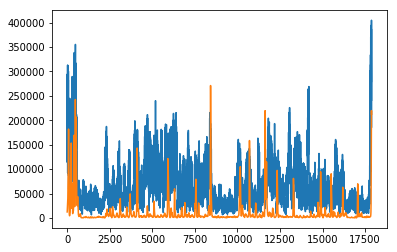

In [17]:
plt.plot(df["alpha_F7_1"])
plt.plot(df["head"]*500)

# 2. Crosscorrelation and time-shift analysis

In [20]:
bounds = 1
alpha = [v[bounds:-bounds] for k, v in df.items() if re.search("alpha",k)]
alpha_trial = [v[2500:7500] for k, v in df.items() if re.search("alpha",k)]
gamma = [v[bounds:-bounds] for k, v in df.items() if re.search("gamma",k)]
gamma_trial =[v[2500:7500] for k, v in df.items() if re.search("gamma",k)]

head_complete = df["head"][bounds:-bounds]
head_trial = df["head"][0:1000]
hands_complete = df["hands"][bounds:-bounds]
hands_trial = df["hands"][0:1000]

................................................................................................................................................

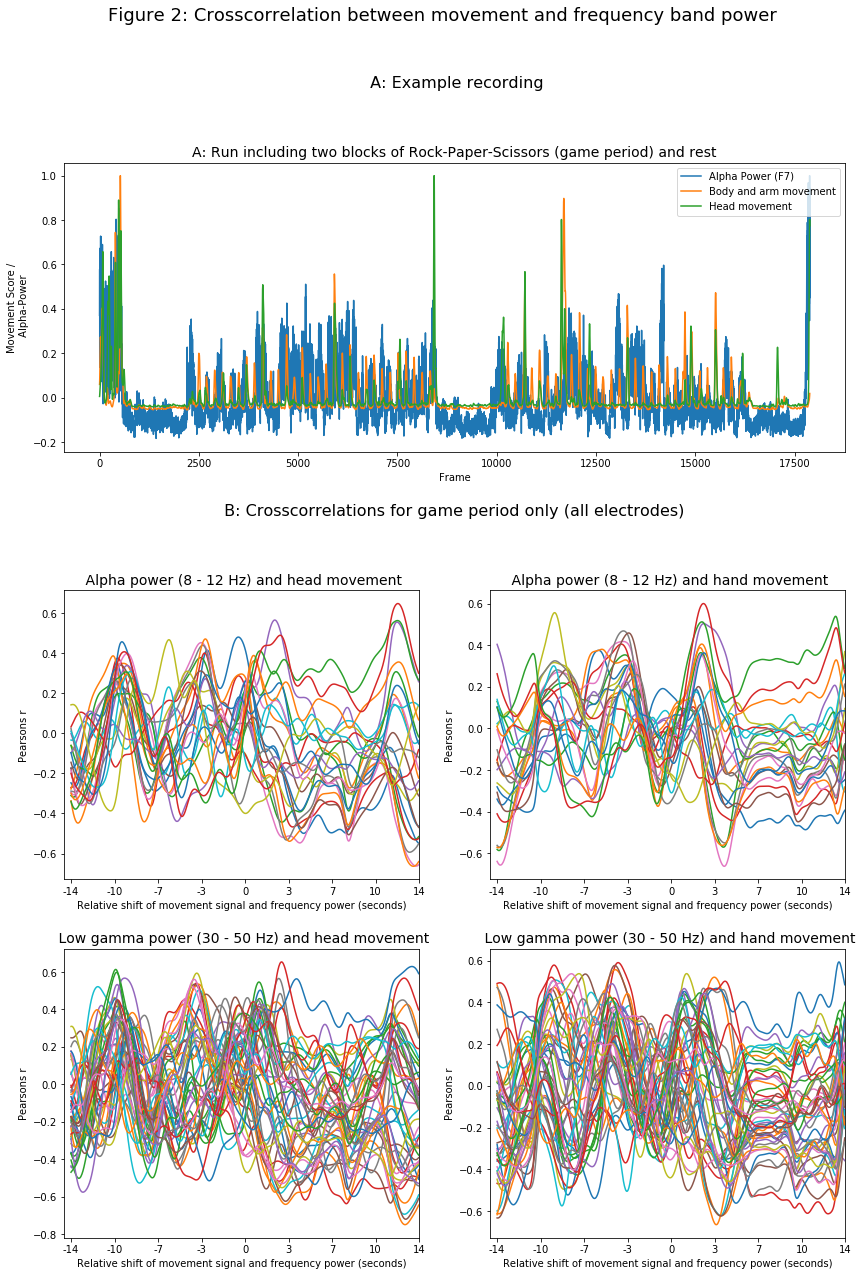

In [21]:
import matplotlib.pyplot as plt
gam = df["alpha_F7_1"]
body = df["body"]
head = df["head"]
hands = df["hands"]


body = body-np.mean(body)
head = head-np.mean(head)
hands = hands-np.mean(hands)

gam = gam-np.nanmean(gam)

#Generate new figure and define arrangement via grid specification

fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(top=0.92, wspace = 0.2, hspace=.4)

fig.suptitle("Figure 2: Crosscorrelation between movement and frequency band power", fontsize=18)
gs = gridspec.GridSpec(5, 2,width_ratios=[1, 1],height_ratios=[0.001,2,0.001,2,2])

ax_empty0 = plt.subplot(gs[0,:])
ax1 = plt.subplot(gs[1,:])
ax_empty1 = plt.subplot(gs[2,:])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[4,0])
ax5 = plt.subplot(gs[4,1])


#Turn off ticks
ax_empty0.axis("off")
ax_empty0.axis("off")
ax_empty0.set_title(" A: Example recording", fontsize=16)

ax_empty1.axis("off")
ax_empty1.axis("off")
ax_empty1.set_title(" B: Crosscorrelations for game period only (all electrodes) ", fontsize=16)


# 1: Add first subplot: Sample trial alpha power and movement signals (unsmoothed)
ax1.plot((gam/np.max(gam)), label="Alpha Power (F7)")
ax1.plot(body/np.max(body), label="Body and arm movement")
ax1.plot(head/np.max(head), label="Head movement")
ax1.legend(loc='best')
ax1.set_xlabel("Frame")
ax1.set_ylabel("Movement Score /\n Alpha-Power")
ax1.set_title("A: Run including two blocks of Rock-Paper-Scissors (game period) and rest", fontsize = 14)

# 2: Add rest
maxshift = 350

titles = []
titles.append(" Alpha power (8 - 12 Hz) and head movement")
titles.append(" Alpha power (8 - 12 Hz) and hand movement")

titles.append(" Low gamma power (30 - 50 Hz) and head movement")
titles.append(" Low gamma power (30 - 50 Hz) and hand movement")


for ax, powers, mot, title in zip([ax2,ax3,ax4,ax5],[alpha_trial,alpha_trial,gamma_trial,gamma_trial],
                      [head_trial,hands_trial,head_trial,hands_trial],titles):
    ax.set_xlim(-14,14)

    ax.set_xticks(np.linspace(0,2*maxshift,9))
    ax.set_xticklabels(np.linspace(-maxshift/25,maxshift/25,9, dtype =np.int32))
    ax.set_xlabel("Relative shift of movement signal and frequency power (seconds)")
    ax.set_ylabel("Pearsons r")
    ax.set_title(title, fontsize = 14)

    for train in powers:
        print(".", end = "")
        if np.any(np.isnan(train)):
            print("Nan in eeg for" + title)
            train[np.isnan(train)] =0
        if np.any(np.isnan(mot)):
            print("Nan in motion for" + title)
            mot[np.isnan(mot)] =0
        c = helper.correlation_shifted(mot,train,maxshift)[0]#We shift eeg relative to motion
        ax.plot(c)

Correlation peaks shortly before zero. If movement is delayed for two seconds there is the strongest positive correlation. 
Possibly, artifacts are generated shortly before movement peaks (if movement is delayed the peak overlaps with the peak in EEG-power causing positive correlation).
An interpretation is that those muscles affecting the EEG signal strongest are active when participants lift their hands to play another round of Rock-Paper and Scissors.
The fact that correlation is stronger in higher frequencies indicates that the effect is rather due to muscle activity then neuronal processes. 
One would expect muscle activity to occur in higher frequencies.

# Correlations and cross-correlations for the dataset

In [58]:
from collections import defaultdict
import seaborn as sns

## Inspection of correlations of the whole dataset

In [19]:
df.iloc[:,0:].corr().round(1).head()

,head,hands,body,head_up,head_left,head_down,head_right,hands_up,hands_left,hands_down,...,shift_p25_body,shift_p50_head,shift_p50_hands,shift_p50_body,shift_p75_head,shift_p75_hands,shift_p75_body,shift_p100_head,shift_p100_hands,shift_p100_body
head,1.0,0.3,0.6,0.5,0.6,0.5,0.6,0.2,0.2,0.3,...,0.4,0.3,0.1,0.3,0.3,0.0,0.2,0.2,0.0,0.1
hands,0.3,1.0,0.8,0.2,0.3,0.1,0.2,0.7,0.7,0.7,...,0.4,0.1,-0.1,0.1,0.0,-0.2,-0.1,0.0,-0.2,-0.1
body,0.6,0.8,1.0,0.3,0.4,0.2,0.3,0.6,0.5,0.6,...,0.6,0.2,-0.0,0.2,0.1,-0.1,-0.0,0.0,-0.1,-0.1
head_up,0.5,0.2,0.3,1.0,0.3,0.1,0.5,0.2,0.1,0.2,...,0.1,0.1,-0.0,0.0,0.1,-0.0,0.0,0.1,0.0,0.0
head_left,0.6,0.3,0.4,0.3,1.0,0.3,0.2,0.3,0.2,0.3,...,0.3,0.1,0.1,0.3,0.2,0.1,0.2,0.1,0.0,0.1


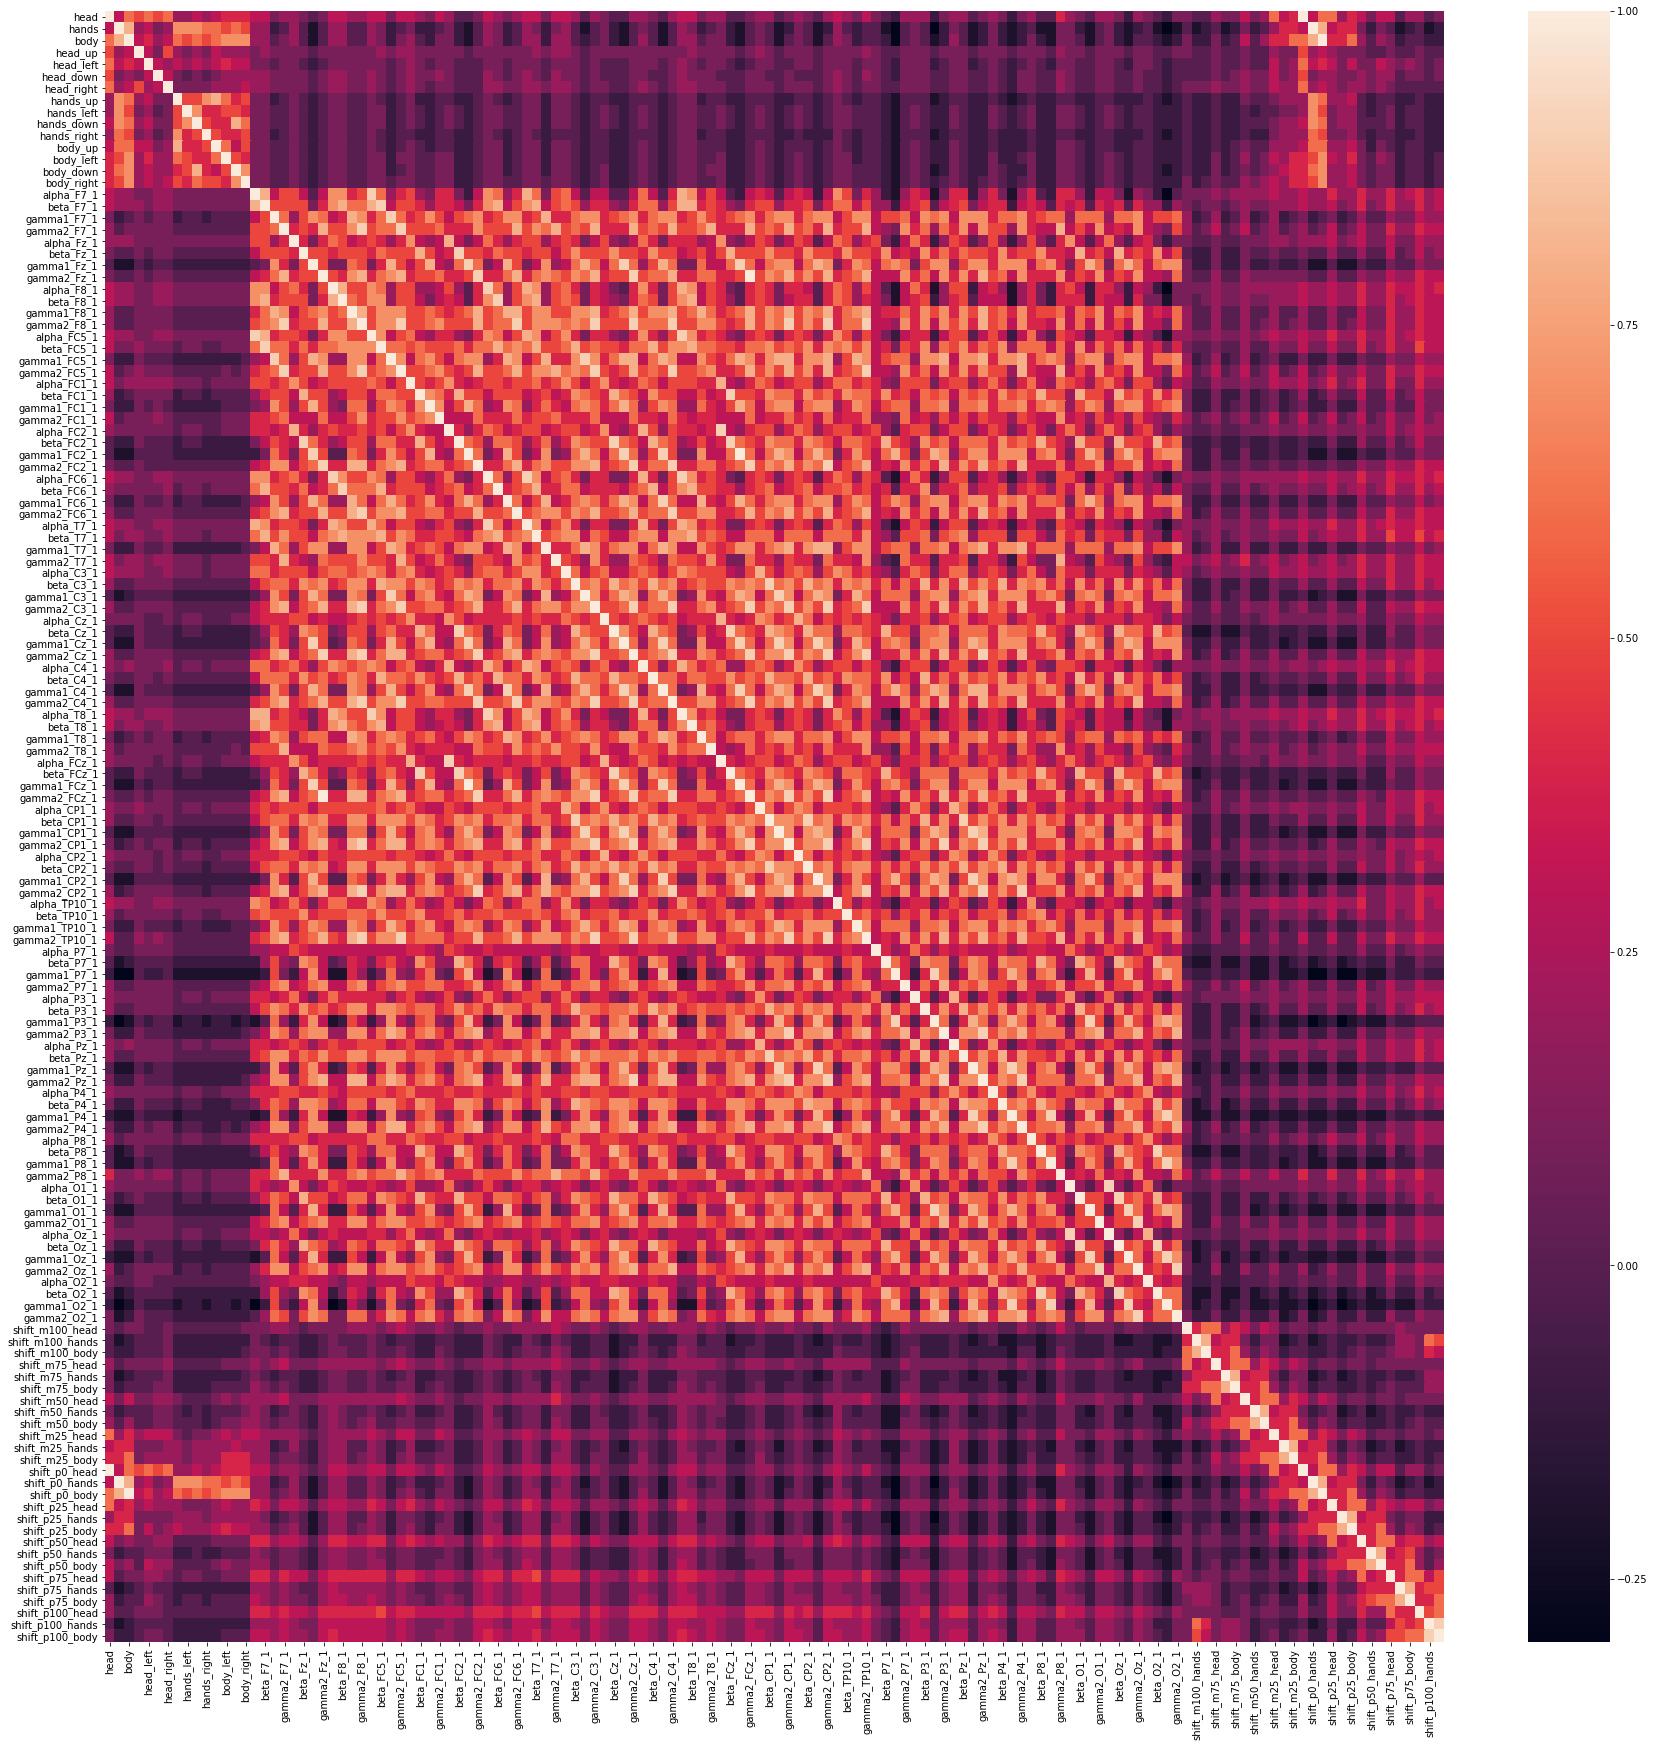

In [20]:
#Check for intercorrelations of 1d motion first
plt.figure(figsize=(30,30))
sns.heatmap(df.iloc[:,0:].corr().round(1), annot=False)

### Conclusions:

- We have high multicolinearity between motion channels (1D signal for motion score)
- Very high multicolinearity also exists between motion directions (2d signal for up, down, right, left)
- It shows that that higher correlations between motion and EEG-Power occur for the shifted 1D motion signal as compared to the non-shifted 1D signal (further investigations below)

## Game period correlations of the non-shifted 1D and 2d motion signal and EEG power

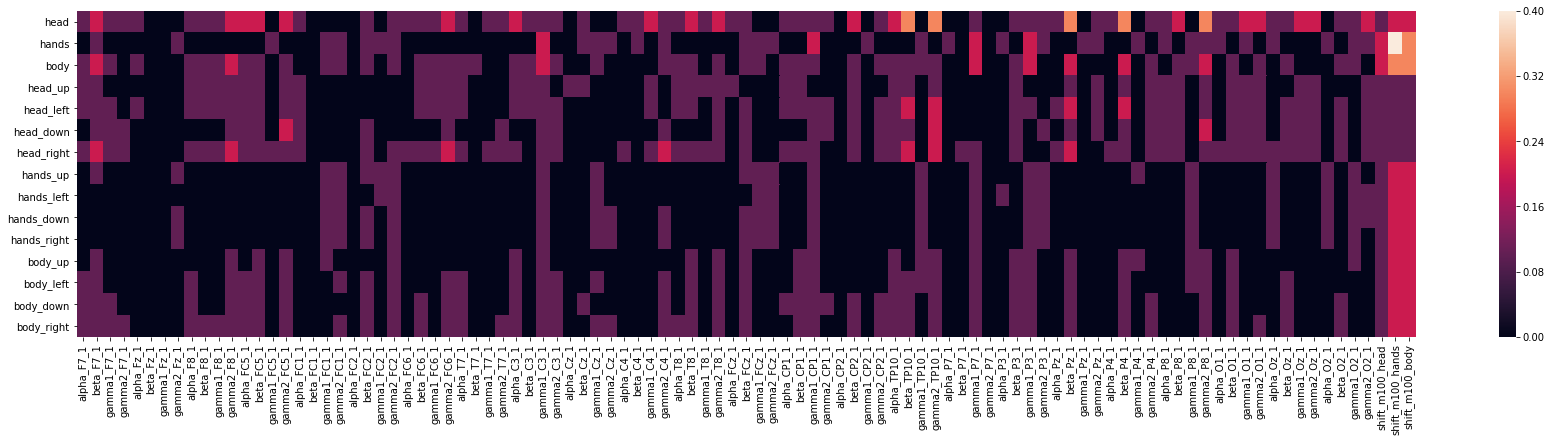

In [21]:
#Check for intercorrelations of 1d motion first
plt.figure(figsize=(30,6))
sns.heatmap(df.iloc[2500:7500,:].corr().round(1).abs().iloc[:15,15:-24], annot=False)

## Within trial period correlations of the shifted 1D motion signal and EEG power

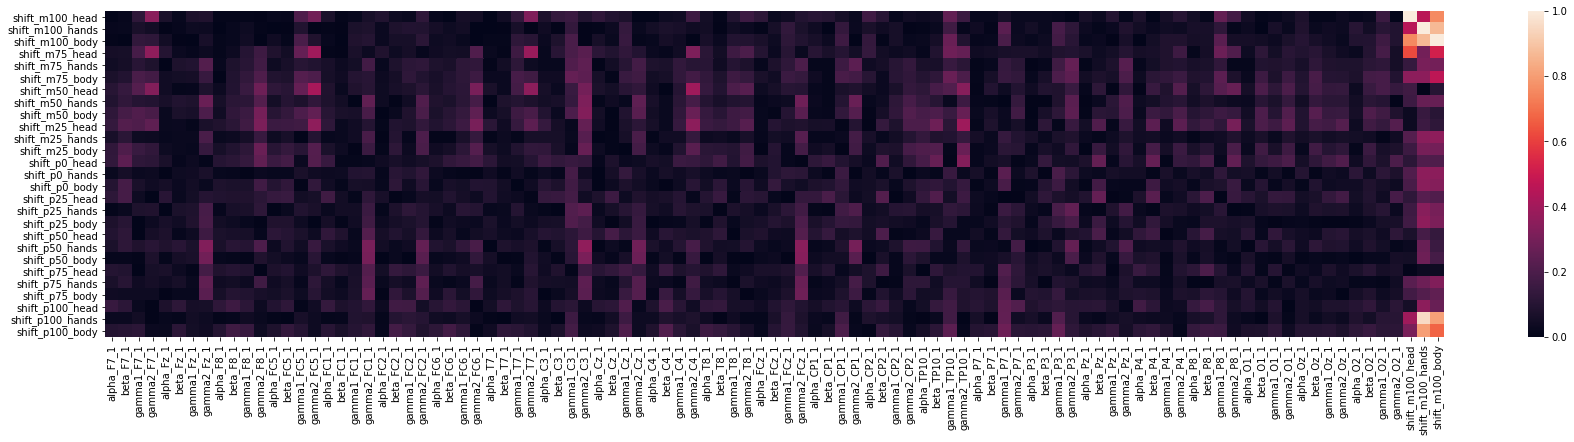

In [22]:
plt.figure(figsize=(30,6))
sns.heatmap(df.iloc[2500:7500,:].corr().abs().iloc[111:,15:-24], annot=False)

It shows that correlations are higher. What is a good shift for better predictions of EEG power given the motion signal (Marginal distribution)?

In [23]:
pd.DataFrame(df.iloc[2500:7500,:].corr().round(1).abs().iloc[115:,15:-18].sum(axis=1))

,0
shift_m75_hands,12.3
shift_m75_body,16.2
shift_m50_head,15.1
shift_m50_hands,12.1
shift_m50_body,16.2
shift_m25_head,13.9
shift_m25_hands,7.4
shift_m25_body,11.4
shift_p0_head,10.9
shift_p0_hands,6.7


A good shift is minus two (if the peak of motion comes two seconds early there is a higher correlation indicating that for the given task a movement related error signal is strongest before/in the inital phase of movement). Now (1) how dows the overall picture for different regions look like and (2) how does the topographical organisation look like?

# Overall (best) correlation of movement and EEG Power for motion ROIs and Frequency bands 

## Prepare dictionaries to accumultate information to be printed in table

For each region for each 1D movement signal. Compute crosscorellations within +3 to -3 seconds. Save the correlation as well as its significance (corrected for the number of comparisons for channels, ROIs and bands, 25X3) to a default dict.
Print the results as a table

In [177]:
alpha = [v[2500:7500] for k, v in df.items() if re.search("alpha",k)]
beta = [v[2500:7500] for k, v in df.items() if re.search("beta",k)]
gamma1 = [v[2500:7500] for k, v in df.items() if re.search("gamma1",k)]
gamma2 = [v[2500:7500] for k, v in df.items() if re.search("gamma2",k)]

head = df["head"][2500:7500]
hands = df["hands"][2500:7500]
body = df["body"][2500:7500]

In [178]:
from scipy import ndimage
from scipy import stats
from IPython.display import HTML

In [179]:
pearsons_r = defaultdict(lambda: defaultdict(dict))
pearsons_r_shifted = defaultdict(lambda: defaultdict(dict))
n_sig = defaultdict(lambda: defaultdict(dict))
n_large = defaultdict(lambda: defaultdict(dict))
mean_shift = defaultdict(lambda: defaultdict(dict))

summery = defaultdict(lambda: defaultdict(dict))

In [180]:
names_regions = ["Head Region", "Body Region", "Hands region"]
names_bands = ["Alpha Power", "Beta power", "Low Gamma Power","High Gamma Power"]
for region, name_region in zip([head, hands, body],names_regions):
    for band, name_band in zip([alpha, beta, gamma1, gamma2],names_bands):
        print(".", end = "")
        mean = 0
        n_greater = 0
        optimal_shift = 0
        mean_p = 0
        
        n_sig_corr = 0
        for electrode in band:
            #region = ndimage.filters.gaussian_filter1d(region,50)
            #band = ndimage.filters.gaussian_filter1d(region,2)
            
            corr, ps = helper.correlation_shifted(electrode,region,75)#shift movement relative to power
            if np.max(np.abs(corr)) >= .2:
                n_greater += 1
                
            shift = np.argwhere(corr==np.max(corr))[0][0]
            optimal_shift += shift-75
            
            mean += np.max(np.abs(corr))
            mean_p += ps[shift]
            
            if ps[shift]<0.05/(25*3*4):
                n_sig_corr+=1
            #print("{0:1.4f}".format(ps[shift]))
            #print(np.max(np.abs(corr)))
        
        mean = mean/len(band)
        optimal_shift = optimal_shift/len(band)
        
        pearsons_r_shifted[name_region][name_band] = mean
        n_large[name_region][name_band]  = n_greater
        mean_shift[name_region][name_band]  = optimal_shift
        n_sig[name_region][name_band] = n_sig_corr
        
        summery[name_region][name_band] = "\t \t \t"+str(n_sig_corr) + "  ( r = {0:1.2f}, shift = {1:1.1f} s )".format(mean,optimal_shift/25)
        
        if(False):            
            print()
            print(name_region)
            print(name_band)
            print("Mean r: ")

            print(mean)
            print("Greater than .2:")
            print(n_greater)
            print("Mean shift for optimal correlation")
            print(optimal_shift)

............

In [181]:
print_table(summery,'Table 1: \t Number of electrodes with a significant correlation of shifted movement and bandpower',4, 
            "Values in parentheses refer to mean correlation and optimal shift. Significance at p* < .05. Corrected for multiple comparisons. N = 5000")

,Head Region,Body Region,Hands region
Alpha Power,"22 ( r = 0.12, shift = -0.8 s )","15 ( r = 0.07, shift = 1.1 s )","22 ( r = 0.10, shift = 0.1 s )"
Beta power,"23 ( r = 0.17, shift = -0.8 s )","20 ( r = 0.09, shift = 2.2 s )","23 ( r = 0.14, shift = 0.8 s )"
High Gamma Power,"24 ( r = 0.25, shift = 1.3 s )","24 ( r = 0.20, shift = 2.1 s )","24 ( r = 0.24, shift = 1.9 s )"
Low Gamma Power,"22 ( r = 0.16, shift = 1.2 s )","24 ( r = 0.14, shift = 2.0 s )","24 ( r = 0.18, shift = 2.1 s )"


# Movement based predictions

Here linear/polynominal regression is used to predict EEG power using movement. Three models are compared for linear and quadratic regression (six formal models)

- 1D and 1d 2d signal
- Shifted vs. non delayed
- Shifted and non-shifted vs. non-shifted


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures
from RegscorePy import aic
import scipy.signal

game_period = pd.DataFrame(df.loc[2500:7500], copy = True)#Affects also original dataframe if not copy when chnaging game_period

In [19]:
from IPython.display import clear_output
import time

In [20]:
if False:#Preprocessing by filtering
    keys_of_channels = game_period.keys()[:]#[15:15+96]#EEG Only
    for k in keys_of_channels:
        
        game_period[k]= game_period[k]-game_period[k].rolling(window=20,center=False).mean()
        pass
    game_period = pd.DataFrame(game_period.loc[:], copy = True)

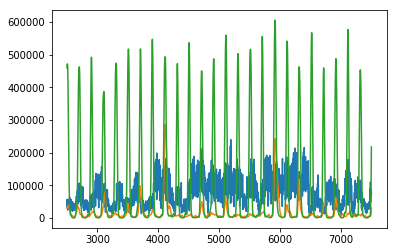

In [21]:
plt.plot(game_period["alpha_F7_1"])
plt.plot(game_period["head"]*1000)
plt.plot(game_period["hands"]*1000)

In [22]:
def polynomial_regression(X_train,X_test, Y_train,Y_test ,degree):
    """Polynomial regression model for the given degree
    Args:
        X_train: Training data; 2 dimensional where each row represents one feature
        Y_train: Training data to predict, 1dimensional
        X_test: Test dataset used to evaluate performance by predicting Y_test. 2D data.
        Y_test: Test dataset target values predicted by X_test. 1D data.
    Returns:
        Akaike criterion for the test dataset
        Pearsons r for the correlaion between prediction and values of the test data
        R-squared for the test Data
        R-squared for the training Data
        Tuple of fitted RegressionModel and polynominal features that are required for future predictions                             
    """

    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)# transform existing features to higher degree features.
    poly_model = LinearRegression()  # fit the transformed features to Linear Regression
    poly_model.fit(X_train_poly, Y_train)

    y_train_predicted = poly_model.predict(X_train_poly)# predicting on training data-set
    y_test_predict = polynominal_predict(X_test,poly_model,poly_features)#poly_model.predict(poly_features.fit_transform(X_test))# predicting on test data-set
    
    #Calculate performance measures
    feature_names = poly_features.get_feature_names(X_train.columns)
    #aic.aic(np.array(Y_test).flatten(),np.array(y_test_predict).flatten(),len(feature_names))
    #np.corrcoef(Y_test, y_test_predict)[0,1]
    r2_test = r2_score(Y_test, y_test_predict)
    r2_train = r2_score(Y_train, y_train_predicted)
    
    return r2_test, r2_train, (Y_test,y_test_predict), (poly_model,poly_features)

def polynominal_predict(data, poly_model, poly_features):
    """ Computes prediction for given data and the polynomonal model as well as the features that result from fit
    Args:
        data: Data of shape N x NumberOfPredictors where NumberOfPredictors matches the explaining variables
                used during prediction. E.g. An array containing lines of predictors.
        poly_model: The fitted regression model (returned by polynominal_regression)
        poly_features: The polinominal features used during fitting (returned by polynominal regression)
        
    Returns:
        Predictions
    """
    return poly_model.predict(poly_features.fit_transform(data))

def leave_free_split(x,y,test_size =.2,chunksize = 25, leave_free = 1):
    """ Splits into training and test data. Leaves leave_free chunks of chunksize free around each test chunk
        x: Data (2D)
        y: Data (1D)
        test_size: proportion of training to test data. Note that the ratio is not accurately matched
        chunksize: Size of the chunks of data that are assembled into trianing and test data
    """
    columns = x.columns.values

    #test_size = .2 --> every fifth chunk is test data
    x = np.array(x)
    y = np.array(y)
    np.append(x,y, axis=1)
    chunks = x.shape[0]//chunksize
    
    chunks = np.array(np.array_split(np.append(x,y, axis=1),chunks))#now we have as many chunks as possible
    
    #next we obtain decriptive-labels for the indices of the chunks
    description = np.ndarray((len(chunks)),dtype=np.object)
    description[:] = "training"

    stepsize = int((1/test_size) + leave_free*2 +1)
    
    for i in range(2*leave_free+1):
        description[i::stepsize] = "free"

    description[leave_free::stepsize] = "test"
    
    #now we can select training and test data accordingly
    training = chunks[description == "training"]
    test = chunks[description == "test"]
    
    
    train_x = np.concatenate(training)[:,0:-1]
    train_y = np.concatenate(training)[:,-1]
    test_x = np.concatenate(test)[:,0:-1]
    test_y = np.concatenate(test)[:,-1]
    
    return pd.DataFrame(train_x, columns = columns), pd.DataFrame(test_x, columns = columns), pd.DataFrame(train_y), pd.DataFrame(test_y)


def n_fold_chunk_split(x,y, n = 10):
    """ Splits data into chunks without overlap. One chunk is the test data the rest is for training.
        Args:
            x: 2d data
            y: 1 data
        Returns:
            List of training and test data
    """    
    columns = x.columns.values
    x = np.array(x)
    y = np.array(y)
    #y = testy.reshape(y.shape[0],1)
  
        
    chunks = np.array(np.array_split(np.append(x,y, axis=1),n))

    training_x = []
    training_y = []
    testset_x = []
    testset_y = []
    for c in range(n):
        test = chunks[c]
        training1 = chunks[0:c]
        training2 = chunks[c+1:]
        
        training = np.append(training2,training1,axis = 0)        
        training = np.concatenate(training,axis=0)

        y_train = training[:,-1]
        x_train = training[:,:-1]
        
        y_test = test[:,-1]
        x_test = test[:,:-1]
        
        training_x.append(pd.DataFrame(x_train, columns=columns))
        training_y.append(pd.DataFrame(y_train))
        testset_x.append(pd.DataFrame(x_test, columns= columns))
        testset_y.append(pd.DataFrame(y_test))
    return training_x, training_y, testset_x, testset_y

In [23]:
if False:#Print some scatterplots?
    print(np.array(game_period.keys()))
    plt.figure(figsize=(20, 5))

    features = ['head', 'hands', "shift_m2_head", "shift_2_head", "shift_1_head", "shift_m1_head"]
    target = game_period['alpha_O1_1']

    for i, col in enumerate(features):
        plt.subplot(1, len(features) , i+1)
        x = game_period[col]
        y = target
        plt.scatter(x, y, marker='o')
        plt.title(col)
        plt.xlabel(col)

## Define output structures for results and predictive models, then train the models

In [24]:
#The results go in here:
quality_measures = []#The resulting measures and their heading (used for printout later)
headers = ["Predictive Model", "Predicted Channel", "Polynominal degree","R-squared (chunked, test)","R-squared(chunked, training)",
          "R-squared (test)","R-squared (training)"]

poly_model_features = []


#Here comes the whole data input:
predictive_datasets = []#The regression model i.e. the data it consists of
predictive_datasets_names = []

targets = []
target_names = []

In [25]:
#Model 1
X = game_period.loc[:,:"body"]#head hands body
predictive_datasets.append(X)
predictive_datasets_names.append("1D-movement score for all regions\n(head, body, hands)")

#Model 2
X = game_period.loc[:,:"body_right"]#head hands body head_left ... body_right
predictive_datasets.append(X)
predictive_datasets_names.append("All movement channels for all regions")

#Model 3
X1 = predictive_datasets.append(game_period.loc[:,'shift_m75_head':'shift_m75_body'])
predictive_datasets_names.append("1D-movement for all regions\nshifted to the past")

#Model 4
X1 = dict(game_period.loc[:,"shift_m75_head":"shift_p75_body"])# Head hands body and shifted
X2 = dict(game_period.loc[:,"head":"body"])
predictive_datasets.append(pd.DataFrame.from_dict({**X1,**X2}))#Information from the past and the future
predictive_datasets_names.append("1D-movement for all regions,\n shifted and non-shifted in time")

#Target values (electrodes)
for k,v in game_period.loc[:,'alpha_F7_1':"gamma2_O2_1"].items():
    target_names.append(k)
    targets.append(v)

In [26]:
#For all models, for all electrodes compute Polynominal regression for degree 1 (Linear regression) and degree 2 (quadratic)
start_time = time.time()


for X, name in zip(predictive_datasets, predictive_datasets_names):#Different models
    for Y, target_name in zip(targets, target_names):#All electrodes
        before_regression = time.time()
        for degree in [1,2]:#Polinominal degree 1 and 2
            #Compute regression and save results for chunked training and test data (randomly selected chunks)
            chunked_r2_test = 0
            chunked_r2_train = 0
            
            r2_test = 0
            r2_train = 0
            
            repetitions = 0
            
            training_x, training_y, testset_x, testset_y = n_fold_chunk_split(X,pd.DataFrame(Y))
            if False:
                for x_train, y_train, x_test, y_test in zip(training_x,training_y,testset_x,testset_y):
                    #x_tr, x_tes, y_tr, y_tes = chunked_train_test_split(X,Y, test_size = 0.2)
                    chunked_r2_te, chunked_r2_tra, test_and_prediction, model = polynomial_regression(x_train,x_test, y_train,y_test, degree)

                    chunked_r2_test += chunked_r2_te
                    chunked_r2_train += chunked_r2_tra
                    repetitions +=1

                    #print(chunked_r2_te)
                                
                
            #Repeat with randomly selected training and test data
            #x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)#NEW NEW NEW

            x_train, x_test, y_train, y_test = leave_free_split(X, pd.DataFrame(Y), .5)
            
            r2_test, r2_train, test_and_prediction, model = polynomial_regression(x_train,x_test, y_train,y_test, degree)
            
            #chunked_r2_test /= repetitions
            #chunked_r2_train /= repetitions

            #Save values
            quality_measures.append([name,target_name,degree,chunked_r2_test,chunked_r2_train,r2_test,r2_train])
            
        total_time_estimate = (time.time()-before_regression)*len(predictive_datasets)*len(targets)
        elapsed = start_time-time.time()
        clear_output()
        print("Total time estimate " + str(total_time_estimate))
        print("Elapsed " + str(elapsed))
        print("Remaining " + str(total_time_estimate+elapsed))

Total time estimate 70.10037231445312
Elapsed -40.478890895843506
Remaining 29.62148141860962


In [27]:
import pickle
with open("prediction_evaluation", "wb") as f:
    pickle.dump(quality_measures,f)
#with open("test_data_and_predictions", "wb") as f:
#    pickle.dump(predictions,f)

In [28]:
print_table(pd.DataFrame(quality_measures, columns = headers))

,Predictive Model,Predicted Channel,Polynominal degree,"R-squared (chunked, test)","R-squared(chunked, training)",R-squared (test),R-squared (training)
0,"1D-movement score for all regions(head, body, hands)",alpha_F7_1,1,0,0,-0.137838,0.052389
1,"1D-movement score for all regions(head, body, hands)",alpha_F7_1,2,0,0,-0.389338,0.097012
2,"1D-movement score for all regions(head, body, hands)",beta_F7_1,1,0,0,-0.127415,0.102497
3,"1D-movement score for all regions(head, body, hands)",beta_F7_1,2,0,0,-0.618456,0.155480
4,"1D-movement score for all regions(head, body, hands)",gamma1_F7_1,1,0,0,-0.180561,0.066381
5,"1D-movement score for all regions(head, body, hands)",gamma1_F7_1,2,0,0,-0.133555,0.158023
6,"1D-movement score for all regions(head, body, hands)",gamma2_F7_1,1,0,0,-0.040897,0.037361
7,"1D-movement score for all regions(head, body, hands)",gamma2_F7_1,2,0,0,-0.026464,0.067808
8,"1D-movement score for all regions(head, body, hands)",alpha_Fz_1,1,0,0,-0.024326,0.000590
9,"1D-movement score for all regions(head, body, hands)",alpha_Fz_1,2,0,0,-0.021808,0.014174


In [29]:
 #pd.DataFrame(quality_measures, columns = headers)["R-squared (chunked, test)"]

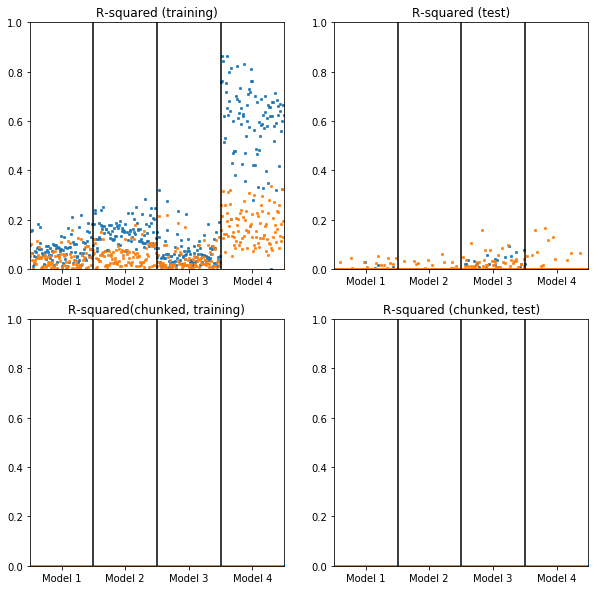

In [30]:
gs = gridspec.GridSpec(2,2,width_ratios=[1,1], height_ratios = [1,1])

plt.figure(figsize = (10,10))

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

axes = [ax1,ax2,ax3,ax4]
keys = ["R-squared (training)","R-squared (test)","R-squared(chunked, training)","R-squared (chunked, test)"]

for ax, key in zip(axes, keys):
    ax.set_title(key)
    part = pd.DataFrame(quality_measures, columns = headers)[key]
    part.iloc[np.array(part.iloc[:])<0] = 0
    quadratic_models = part.iloc[1::2]
    linear_models = part.iloc[::2]

    ax.plot(quadratic_models,linestyle="",marker="X", markersize = 2)
    ax.plot(linear_models,linestyle="",marker="X", markersize = 2)
    ax.set_ylim(0,1)
    ax.set_xlim(0,767)

    ax.axvline(x=191, color='k')
    ax.axvline(x=384, color='k')
    ax.axvline(x=576, color='k')
    ax.set_xticks([96,286,480,672])
    ax.set_xticklabels(["Model 1","Model 2","Model 3","Model 4"])

# Topographical arrangement

## Imports and configuration of the topography of the cap in use. 

The helper method returns a dictionary that maps keys from the dataframe to positions in an array for the given electrode. The latter may be passed to the mne printig function

In [110]:
import mne
import scipy.io
import re

In [111]:
mat = scipy.io.loadmat('acticap-64ch-standard2.mat')

In [112]:
coords = mat["lay"][0][0][0]

In [113]:
labels = [x[0][0] for x in mat["lay"]["label"][0][0]]

In [114]:
#1. What is the index for the df key?
#2. We know indices for mat names
#3. We need to match df-names to mat-names
dfk_to_matk = {}#dataframe key to matfile key

for k,v in df.items():
    #find out what label matches to current k
    found = False
    for l in labels:
        if "_"+ l +"_" in k:
            dfk_to_matk[k] = l
            found = True
        elif "_FCz_" in k:
            dfk_to_matk[k] = "Ref"
            found = True
    if not found:
        #we didnt find a label (matfile) for the key
        #print(k)
        pass
    
#4. Remove umatched matnames and respective coordinates in parallel (readd them to new list)
used_matk = set(dfk_to_matk.values())
    

In [115]:
new_labels = []
new_coordinates = []
for used in used_matk:
    idx = labels.index(used)
    new_labels.append(labels[idx])
    new_coordinates.append(coords[idx])

#5. Match matfile key to index   
matk_to_idx = {}
for k in dfk_to_matk.values():
    matk_to_idx[k] = new_labels.index(k)
    
new_coordinates = np.array(new_coordinates)

In [116]:
matk_to_idx[dfk_to_matk["alpha_F7_1"]]

11

6


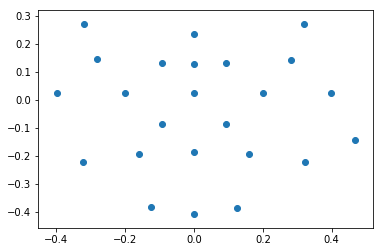

In [117]:
plt.scatter(new_coordinates[:,0],new_coordinates[:,1])
print(new_labels.index("F8"))

In [118]:
def topomap_adapter(corr):
    power_for_electrode = np.zeros(24)#not all channels are used
    power_for_electrode[:] = np.nan
    for k, v in corr.items():
        power_for_electrode[matk_to_idx[dfk_to_matk[k]]] = v#for head, hands or body
    return power_for_electrode

### Now we can print to head

In [119]:
df.iloc[2500:7500,:].corr().iloc[111:,15:-18].index

Index(['shift_m100_head', 'shift_m100_hands', 'shift_m100_body',
       'shift_m75_head', 'shift_m75_hands', 'shift_m75_body', 'shift_m50_head',
       'shift_m50_hands', 'shift_m50_body', 'shift_m25_head',
       'shift_m25_hands', 'shift_m25_body', 'shift_p0_head', 'shift_p0_hands',
       'shift_p0_body', 'shift_p25_head', 'shift_p25_hands', 'shift_p25_body',
       'shift_p50_head', 'shift_p50_hands', 'shift_p50_body', 'shift_p75_head',
       'shift_p75_hands', 'shift_p75_body', 'shift_p100_head',
       'shift_p100_hands', 'shift_p100_body'],
      dtype='object')

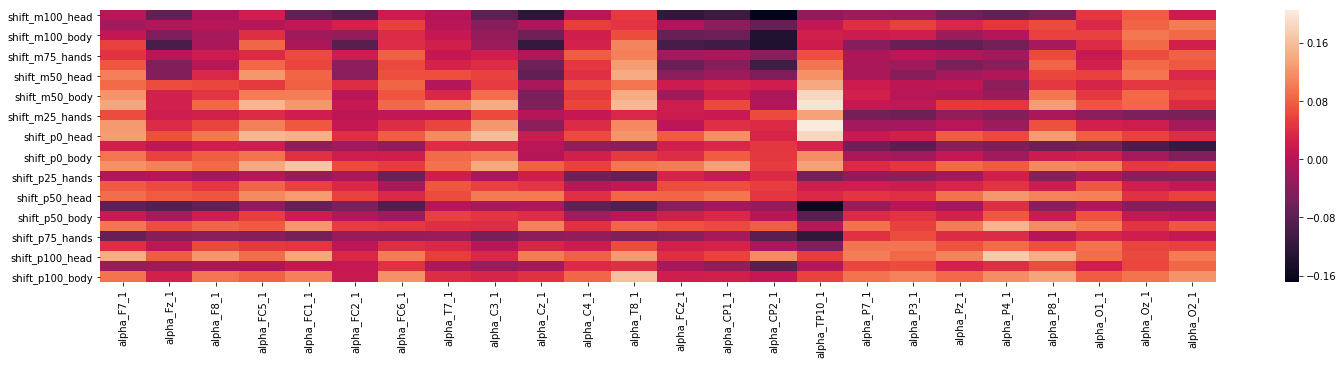

In [144]:
plt.figure(figsize=(25,5))
#               trial period     part shift_mot x power   alpha only
sns.heatmap(df.iloc[2500:7500,:].corr().iloc[111:,15:-28].iloc[:,0::4])

In [153]:
corrs = {}
indices = ['shift_m2_hands', 'shift_m2_body', 'shift_m1_head', 'shift_m1_hands',
       'shift_m1_body', 'shift_1_head', 'shift_1_hands', 'shift_1_body',
       'shift_2_head', 'shift_2_hands', 'shift_2_body', 'shift_3_head',
       'shift_3_hands', 'shift_3_body']

shifted_mot_x_channels = df.iloc[2500:7500,:].corr().iloc[114:,15:-27]
indices = shifted_mot_x_channels.index
print(indices)

corr_per_band_hands = [[],[],[],[]]
corr_per_band_body = [[],[],[],[]]
corr_per_band_head = [[],[],[],[]]

for i in indices:
    print(".",end="")
    alpha =  shifted_mot_x_channels.iloc[:,0::4].loc[i,:]
    beta =   shifted_mot_x_channels.iloc[:,1::4].loc[i,:]
    gamma1 = shifted_mot_x_channels.iloc[:,2::4].loc[i,:]
    gamma2 = shifted_mot_x_channels.iloc[:,3::4].loc[i,:]
    corrs["alpha_"+i] = alpha
    corrs["beta_"+i] = beta
    corrs["gamma1_"+i] = gamma1
    corrs["gamma2_"+i] = gamma2
    
    corr_per_band = None
    if "hands" in i:
        corr_per_band = corr_per_band_hands
    if "body" in i:
        corr_per_band = corr_per_band_body
    if "head" in i:
        corr_per_band = corr_per_band_head
        
    
    corr_per_band[0].append(alpha)
    corr_per_band[1].append(beta)
    corr_per_band[2].append(gamma1)
    corr_per_band[3].append(gamma2)
    

Index(['shift_m75_head', 'shift_m75_hands', 'shift_m75_body', 'shift_m50_head',
       'shift_m50_hands', 'shift_m50_body', 'shift_m25_head',
       'shift_m25_hands', 'shift_m25_body', 'shift_p0_head', 'shift_p0_hands',
       'shift_p0_body', 'shift_p25_head', 'shift_p25_hands', 'shift_p25_body',
       'shift_p50_head', 'shift_p50_hands', 'shift_p50_body', 'shift_p75_head',
       'shift_p75_hands', 'shift_p75_body', 'shift_p100_head',
       'shift_p100_hands', 'shift_p100_body'],
      dtype='object')
........................

In [154]:
#fig, ax = plt.subplots(1)
#a = mne.viz.plot_topomap(topomap_adapter(corrs["gamma1_shift_m2_head"]),np.array(new_coordinates))


In [155]:
corrs["gamma1_shift_m50_head"]
corr_per_band_head[0][0]

alpha_F7_1      0.057390
alpha_Fz_1     -0.096931
alpha_F8_1     -0.012526
alpha_FC5_1     0.085000
alpha_FC1_1    -0.008329
alpha_FC2_1    -0.082269
alpha_FC6_1     0.039632
alpha_T7_1      0.025061
alpha_C3_1     -0.023068
alpha_Cz_1     -0.117027
alpha_C4_1      0.027642
alpha_T8_1      0.109616
alpha_FCz_1    -0.097342
alpha_CP1_1    -0.104823
alpha_CP2_1    -0.136966
alpha_TP10_1    0.018853
alpha_P7_1     -0.042723
alpha_P3_1     -0.068028
alpha_Pz_1     -0.074001
alpha_P4_1     -0.056878
alpha_P8_1     -0.014592
alpha_O1_1      0.037725
alpha_Oz_1      0.088024
alpha_O2_1      0.024644
Name: shift_m75_head, dtype: float64

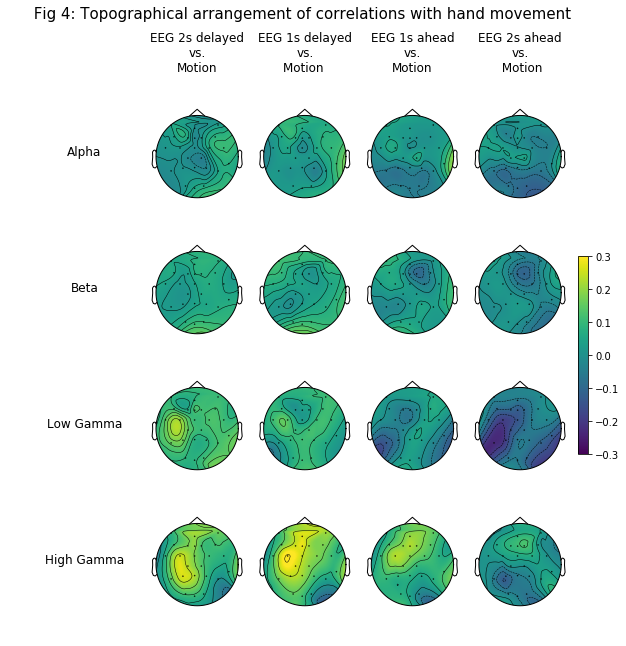

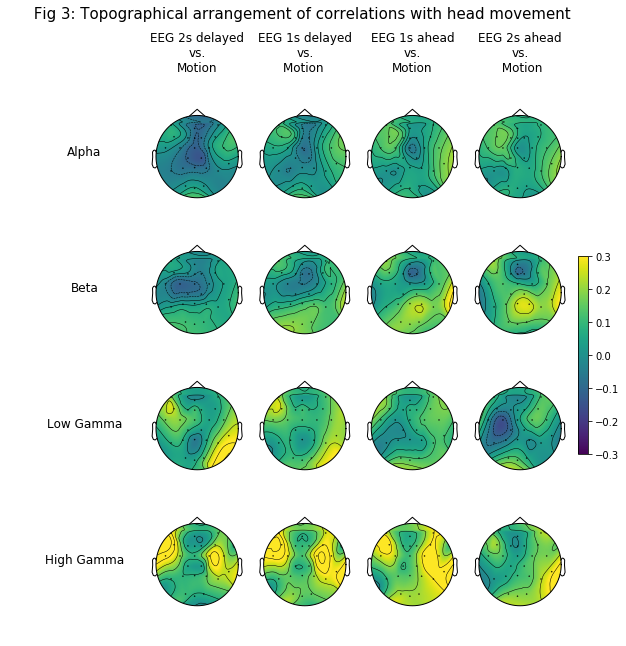

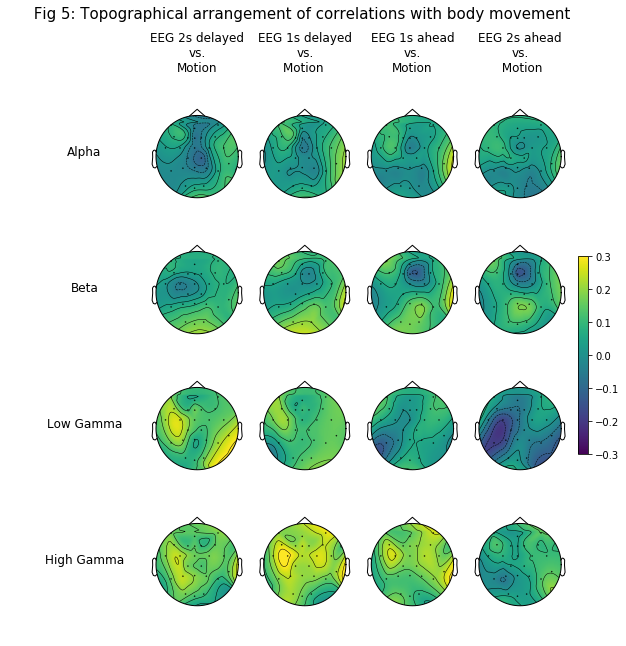

In [185]:
corrs_per_bands = [corr_per_band_hands,corr_per_band_head,corr_per_band_body]
for corr_per_band, roi, figno in zip(corrs_per_bands,["hand","head","body"],[4,3,5]):
    gs = gridspec.GridSpec(5, 6,width_ratios=[1.1,1, 1,1,1,.1],height_ratios=[.4,1,1,1,1])
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(top=0.9, wspace = 0.1,hspace=.1)
    fig.suptitle(" Fig " + str(figno)+": Topographical arrangement of correlations with " + roi + " movement", fontsize=15)
    #fig.suptitle("Figure 2: Crosscorrelation between movement and frequency band power")


    freqs = ["","Alpha","Beta","Low Gamma","High Gamma"]
    delay = ["","EEG 2s delayed\nvs.\nMotion","EEG 1s delayed\nvs.\nMotion ","EEG 1s ahead\nvs.\nMotion","EEG 2s ahead\nvs.\n Motion"]
    for y in range(0,5):
        for x in range(0,5):
            ax = plt.subplot(gs[y,x])
            if x == 0 and y == 0:
                ax.axis("off")
                continue
            if x == 0 or y == 0:
                if y == 0:
                    text = delay[x]
                if x == 0:
                    text = freqs[y]
                ax.text(.5,0.5, text,
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=12,
                            transform=ax.transAxes)
                ax.axis("off")
                continue
            im,_ = mne.viz.plot_topomap(topomap_adapter(corr_per_band[y-1][x-1]),np.array(new_coordinates), 
                                cmap='viridis', vmin=-.3, vmax=.3, show=False, axes=ax)

    cbax = plt.subplot(gs[1:,-1])
    cbax.axis("off")

    fig.colorbar(im,ax=cbax, fraction=1)
    plt.show()